In [2]:
# ============================================================
# MIS581 – Crypto Capstone Project
# Python Module (JupyterLab)
# ============================================================
# Purpose:
#   Analyze 65 cryptocurrencies across 10 narratives
#   Evaluate ROI, Volatility, and Resilience metrics
#   Generate cleaned exports for SQL, SAS, and Tableau integration
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [3]:
# Define your data paths
base_path = r"C:\Users\kevin\OneDrive\Desktop\Crypto Narrative Analysis"
data_path = os.path.join(base_path, "Data", "processed")
export_path = os.path.join(base_path, "Analysis", "python_outputs")

# Load your cleaned datasets
coin_summary = pd.read_csv(os.path.join(data_path, "coin_summary.csv"))
coin_resilience = pd.read_csv(os.path.join(data_path, "coin_resilience.csv"))

print("✅ Data loaded successfully")
print("coin_summary shape:", coin_summary.shape)
print("coin_resilience shape:", coin_resilience.shape)


✅ Data loaded successfully
coin_summary shape: (65, 10)
coin_resilience shape: (65, 5)


In [4]:
print("\nSample rows from coin_summary:")
print(coin_summary.head(3))

print("\nSample rows from coin_resilience:")
print(coin_resilience.head(3))



Sample rows from coin_summary:
   coin        category         tier  mean_price  median_price  vol_daily  \
0  AAVE  DeFi Protocols        Major  166.290889    115.027238   0.059479   
1   ADA   Blue Chip L1s    Blue Chip    0.494242      0.351605   0.065804   
2  AERO       AI & Tech  Speculative    0.732064      0.711793   0.098671   

   roi_1y_med  roi_3y_med  roi_5y_med  n_days  
0    0.172785   -0.191758         NaN    1777  
1    0.157075    2.669299     5.87246    2857  
2    1.234474         NaN         NaN     699  

Sample rows from coin_resilience:
   coin        category         tier  max_drawdown  recovery_days
0  AAVE  DeFi Protocols        Major     -0.921713            NaN
1   ADA   Blue Chip L1s    Blue Chip     -0.979891          351.0
2  AERO       AI & Tech  Speculative     -0.858859            NaN


In [5]:
coin_metrics = pd.merge(
    coin_summary,
    coin_resilience[['coin', 'max_drawdown', 'recovery_days']],
    on="coin",
    how="left"
)
print("\n✅ coin_metrics built successfully")
print(coin_metrics.head(3))



✅ coin_metrics built successfully
   coin        category         tier  mean_price  median_price  vol_daily  \
0  AAVE  DeFi Protocols        Major  166.290889    115.027238   0.059479   
1   ADA   Blue Chip L1s    Blue Chip    0.494242      0.351605   0.065804   
2  AERO       AI & Tech  Speculative    0.732064      0.711793   0.098671   

   roi_1y_med  roi_3y_med  roi_5y_med  n_days  max_drawdown  recovery_days  
0    0.172785   -0.191758         NaN    1777     -0.921713            NaN  
1    0.157075    2.669299     5.87246    2857     -0.979891          351.0  
2    1.234474         NaN         NaN     699     -0.858859            NaN  


In [6]:
# ROI by Category
anova_category = smf.ols('roi_1y_med ~ C(category)', data=coin_summary).fit()
anova_results_category = anova_lm(anova_category)
print("=== ANOVA: ROI_1Y ~ Category ===")
print(anova_results_category)

# Tukey HSD
tukey_category = pairwise_tukeyhsd(
    coin_summary['roi_1y_med'],
    coin_summary['category'],
    alpha=0.05
)
print("\n--- Tukey HSD (Category) ---")
print(tukey_category)


=== ANOVA: ROI_1Y ~ Category ===
               df      sum_sq   mean_sq         F  PR(>F)
C(category)  10.0   74.548200  7.454820  2.474488  0.0166
Residual     52.0  156.658914  3.012671       NaN     NaN

--- Tukey HSD (Category) ---
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1             group2       meandiff p-adj lower upper reject
-----------------------------------------------------------------------
         AI & Tech      Blue Chip L1s   0.1056   nan   nan   nan  False
         AI & Tech     DeFi Protocols  -0.8592   nan   nan   nan  False
         AI & Tech       Emerging L1s  -0.5923   nan   nan   nan  False
         AI & Tech     Infrastructure      nan   nan   nan   nan  False
         AI & Tech           Layer 2s  -0.7342   nan   nan   nan  False
         AI & Tech   Meme & Community   2.6268   nan   nan   nan  False
         AI & Tech Metaverse & Gaming  -0.8705   nan   nan   nan  False
         AI & Tech       Next-Gen L1s   0.4

In [7]:
anova_tier = smf.ols('roi_1y_med ~ C(tier)', data=coin_summary).fit()
anova_results_tier = anova_lm(anova_tier)
print("\n=== ANOVA: ROI_1Y ~ Tier ===")
print(anova_results_tier)

tukey_tier = pairwise_tukeyhsd(
    coin_summary['roi_1y_med'],
    coin_summary['tier'],
    alpha=0.05
)
print("\n--- Tukey HSD (Tier) ---")
print(tukey_tier)



=== ANOVA: ROI_1Y ~ Tier ===
            df      sum_sq   mean_sq         F    PR(>F)
C(tier)    2.0   13.986774  6.993387  1.931694  0.153808
Residual  60.0  217.220340  3.620339       NaN       NaN

--- Tukey HSD (Tier) ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1     group2   meandiff p-adj lower upper reject
-------------------------------------------------------
Blue Chip       Major      nan   nan   nan   nan  False
Blue Chip Speculative      nan   nan   nan   nan  False
    Major Speculative      nan   nan   nan   nan  False
-------------------------------------------------------


In [8]:
# ROI vs Volatility
print("\n=== Regression: ROI_1Y ~ vol_daily ===")
reg1 = smf.ols('roi_1y_med ~ vol_daily', data=coin_summary).fit()
print(reg1.summary())

# ROI vs Resilience Metrics
print("\n=== Regression: ROI_1Y ~ max_drawdown + recovery_days ===")
res_reg = smf.ols('roi_1y_med ~ max_drawdown + recovery_days', data=coin_metrics).fit()
print(res_reg.summary())



=== Regression: ROI_1Y ~ vol_daily ===
                            OLS Regression Results                            
Dep. Variable:             roi_1y_med   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7891
Date:                Sat, 04 Oct 2025   Prob (F-statistic):              0.378
Time:                        03:16:00   Log-Likelihood:                -129.94
No. Observations:                  63   AIC:                             263.9
Df Residuals:                      61   BIC:                             268.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [9]:
tier_profile = (
    coin_metrics
    .groupby("tier")
    .agg(
        n_coins=('roi_1y_med', 'count'),
        mean_roi_1y=('roi_1y_med', 'mean'),
        std_roi_1y=('roi_1y_med', 'std'),
        mean_vol=('vol_daily', 'mean'),
        std_vol=('vol_daily', 'std'),
        mean_drawdown=('max_drawdown', 'mean'),
        std_drawdown=('max_drawdown', 'std'),
        mean_recovery=('recovery_days', 'mean'),
        std_recovery=('recovery_days', 'std')
    )
    .reset_index()
)
print("\n=== Tier Profile ===")
print(tier_profile)



=== Tier Profile ===
          tier  n_coins  mean_roi_1y  std_roi_1y  mean_vol   std_vol  \
0    Blue Chip        5     0.746068    0.517932  0.140212  0.188372   
1        Major       33     0.166290    1.229210  0.086497  0.144241   
2  Speculative       25     1.154032    2.644150  0.112591  0.165139   

   mean_drawdown  std_drawdown  mean_recovery  std_recovery  
0      -0.913243      0.067812        523.000    335.216348  
1      -0.741303      0.343991        580.400    606.951435  
2      -0.882697      0.194752        546.375    678.625909  


In [10]:
category_perf = (
    coin_metrics
    .groupby("category")
    .agg(
        n_coins=("coin", "count"),
        avg_roi_1y=("roi_1y_med", "mean"),
        std_roi_1y=("roi_1y_med", "std"),
        avg_vol=("vol_daily", "mean"),
        avg_drawdown=("max_drawdown", "mean"),
        avg_recovery=("recovery_days", "mean")
    )
    .reset_index()
)
print("\n=== Category Performance ===")
print(category_perf)



=== Category Performance ===
              category  n_coins  avg_roi_1y  std_roi_1y   avg_vol  \
0            AI & Tech        6    0.640439    0.828121  0.087994   
1        Blue Chip L1s        5    0.746068    0.517932  0.140212   
2       DeFi Protocols        6   -0.218771    0.226308  0.069154   
3         Emerging L1s        6    0.048154    0.293069  0.062282   
4       Infrastructure        6    0.335358    0.391693  0.056277   
5             Layer 2s        7   -0.093809    0.622038  0.059448   
6     Meme & Community        8    3.267193    4.413666  0.343979   
7   Metaverse & Gaming        6   -0.230032    0.186406  0.080354   
8         Next-Gen L1s        5    1.061189    1.731237  0.068337   
9       Payments & RWA        5    0.087453    0.051502  0.038691   
10         Stablecoins        5   -0.000314    0.000252  0.005761   

    avg_drawdown  avg_recovery  
0      -0.959093    809.333333  
1      -0.913243    523.000000  
2      -0.907731           NaN  
3      -0

In [11]:
os.makedirs(export_path, exist_ok=True)

coin_metrics.to_csv(os.path.join(export_path, "py_coin_metrics.csv"), index=False)
tier_profile.to_csv(os.path.join(export_path, "py_tier_profile.csv"), index=False)
category_perf.to_csv(os.path.join(export_path, "py_category_performance.csv"), index=False)

print(f"\n✅ Exported all Python outputs to:\n{export_path}")



✅ Exported all Python outputs to:
C:\Users\kevin\OneDrive\Desktop\Crypto Narrative Analysis\Analysis\python_outputs


C:\Users\kevin\AppData\Local\Temp\ipykernel_26856\291884378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_perf, x='category', y='avg_roi_1y', palette='coolwarm')


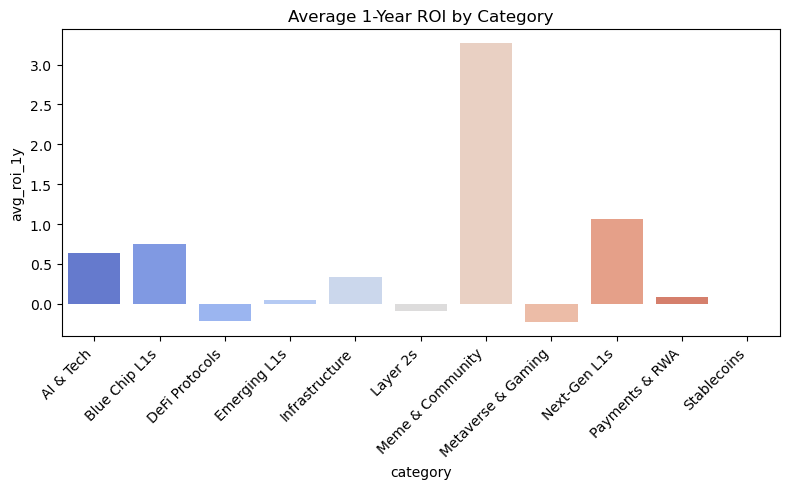

In [12]:
plt.figure(figsize=(8,5))
sns.barplot(data=category_perf, x='category', y='avg_roi_1y', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Average 1-Year ROI by Category')
plt.tight_layout()
plt.savefig(os.path.join(export_path, "plots", "ROI_by_Category.png"))
plt.show()
